# My first attempt with tensorflow probability and edward

11 Jan 2019 Dennis Liu

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow_probability import edward2 as ed

In [4]:
print(tf.__version__)

1.12.0


I will be following the tutorial presented at [this page](https://www.tensorflow.org/tutorials/keras/basic_regression), but using edward and tensorflow probability, rather than base tf.

It uses the Auto MPG dataset and build a regression to predict fuel efficiency.

## Import the data

In [5]:
##Download the Auto MPG dataset
data_path = tf.keras.utils.get_file('auto-mpg.data', \
                                    "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")


In [6]:
#Examine dataset using pandas
columns = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

df_raw = pd.read_csv(data_path, names=columns, na_values='?', comment='\t', sep=" ", skipinitialspace=True)

#to ensure we don't modify raw data
df = df_raw.copy()
df.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Clean data

As many of us are familiar with the dataset, we know there exist some NA values.

In [7]:
df.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

At this stage we will simply drop these rows.

In [8]:
df = df.dropna()
## Check dropped succesfully
df.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Again, we know the nature of the Origin column is actually a catgorical representation, with 1 = USA, 2 = Europe, and 3 = Japan.

Convert this single column into 3 dummy variable columns.

In [9]:
df['USA'] = df.Origin.map(lambda x: x==1).astype(int)
df['Europe'] = df.Origin.map(lambda x: x ==2).astype(int)
df['Japan'] = df.Origin.map(lambda x: x ==3).astype(int)
df = df.drop(columns='Origin')
df.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


## Split the data for cross validation

It is always a good idea (given adequate data size) to split the data into train and test sets. It is one of many ways to check you are not overfitting to the data. However, always remember that checking against the test set only gives a sign of danger, but never of safety (see McElreath, 2016).

Split the data in the same method as the aforementioned tutorial, for consistency to compare results

In [10]:

df_train = df.sample(frac=0.8, random_state=0)
df_test = df.drop(df_train.index)


In [44]:
for dtype in ['float','integer']:
    col_change = df_train.select_dtypes(include=dtype).columns
    df_train[col_change] = df_train.select_dtypes(include=dtype).apply(pd.to_numeric,downcast=dtype)

df_train.dtypes

Cylinders          int8
Displacement    float32
Horsepower      float32
Weight          float32
Acceleration    float32
Model Year         int8
USA                int8
Europe             int8
Japan              int8
dtype: object

## Inspect the data

Due to our familiarity with the data, we could skip this part of the tutorial. However, it is always a good idea to remind ourselves of the scale of the predicotrs and if there are any correlations or colinearity to be aware of. 

We will skip observing the statistics intentionally as a learning exercise.

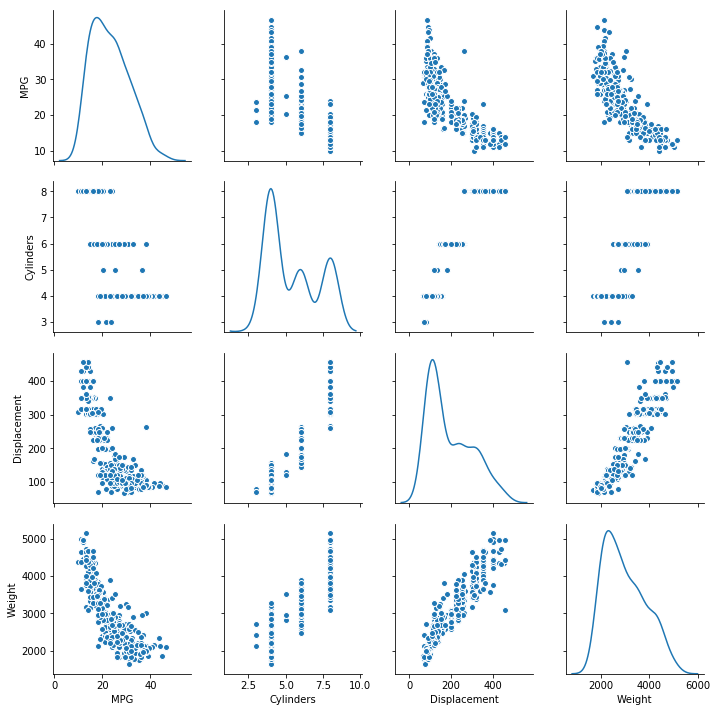

In [11]:
sns.pairplot(df_train[['MPG','Cylinders','Displacement','Weight']], diag_kind='kde')

## Split our response from the data sets

As an exercise, it is always good to think about and remind ourselves what we are trying to predict or learn about. Here, it is the relationship of a car's features to its fuel efficiency.


In [12]:
response = df_train.pop('MPG')
y_test = df_test.pop('MPG')

## Build the model

It appears all the tensorflow tutorials build their models into functions that return the parameters of interest. 

We will follow this convention as I have no strong reasoning to break convention.

Our model will be the standard linear regression model:

    y_i ~ Normal (x_i *\beta + b, \sigma)

with priors:

    \beta ~ Normal (0, 10)
    log(\sigma) ~ Normal(5, 1)
    b ~ Normal (0, 10)

In [150]:
def mpg_model_log_prob(num_predictors, design_matrix, y, beta, logsigma,b):
    rv_beta = tfd.MultivariateNormalDiag(
        loc = tf.zeros(num_predictors,),
        scale_identity_multiplier = 10.*tf.ones(num_predictors),
        name = 'beta') # priors for beta
    rv_logsigma = tfd.Normal(
        loc = 5.,
        scale = 1.,
        name='logsigma') #prior for log sigma
    
    rv_b = tfd.Normal(
        loc = 0,
        scale = 10,
        name='b') #prior for b
    loc = tf.matmul(design_matrix,rv_beta)
    loc=loc +rv_b
    rv_response = tfd.Normal(
        loc = loc,
        scale = tf.exp(logsigma),
        name = 'response') #y_i 
    
    return ( rv_beta.log_prob(beta)
            +rv_logsigma.log_prob(logsigma)
            + rv_b.log_prob(b)
            + tf.reduce_sum(rv_response.log_prob(y)))




In [151]:
num_iterations =1000

num_warmup = num_iterations//2

# Set the chain's start state.
initial_chain_state = [
            tf.zeros(df_train.shape[1], name='init_beta'),
            tf.ones([], name='init_logsigma'),
            tf.zeros([], name='init_b')
]

# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: mpg_model_log_prob(df_train.shape[1],
                                                                   df_train.values,
                                                                   response.values, *args)

# Initialize the step_size. (It will be automatically adapted.)
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(0.5, dtype=tf.float64),
        trainable=False,
        use_resource=True
    )


states, kernel_results = tfp.mcmc.sample_chain(
    num_results = num_iterations,
    num_burnin_steps = num_warmup,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        step_size=0.01,
        num_leapfrog_steps=4))

logsigma, b = states

TypeError: Failed to convert object of type <class 'tensorflow_probability.python.distributions.mvn_diag.MultivariateNormalDiag'> to Tensor. Contents: tfp.distributions.MultivariateNormalDiag("mcmc_sample_chain_60/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/beta/", batch_shape=(9,), event_shape=(9,), dtype=float32). Consider casting elements to a supported type.

In [99]:

with tf.Session() as sess:
    [a,c,acc] = sess.run([logsigma,b, kernel_results.is_accepted])



## References

* McElreath, R. 2016, *Statistical Rethinking*, Taylor & Francis Group

In [135]:
beta.get_shape

NameError: name 'beta' is not defined

In [70]:
x.shape

TensorShape([Dimension(10)])